In [3]:

import numpy,scipy,scipy.ndimage,zlib,pylab
from pylab import imread,imshow,savefig
from scipy import linalg,ndimage
from scipy.ndimage import interpolation,filters,morphology,measurements,fourier
from scipy.linalg import norm
from scipy.fftpack import fft,ifft,fft2,ifft2
figsize(8,8)

# Sample Data for Line Finding

In [4]:
image = transpose(imread("points.png")[::-1,:,0])
labels,n = measurements.label(image)
points = array(measurements.center_of_mass(image,labels,range(1,n)))

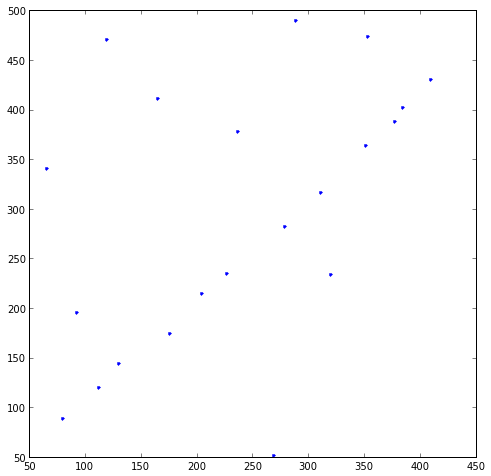

In [5]:
plot(points[:,0],points[:,1],'.')

# RAST Algorithm

As in the Hough transform, the RAST algorithm consider the parameter space spanned by $m$ and $b$.

However, while the Hough transform computes fixed buckets and relies on samples to land in the same bucket by chance, the RAST algorithm computes exact upper bounds on the possible match for a range of parameters.

Assume we consider $m\in[\underline m,\overline m]$, $b\in[\underline b,\overline b]$

For simplicity, assume $m\ge 0$.

Then the predicted $\hat{y} \in [\underline y,\overline y]$, where:

$$ \underline y = \underline m x + \underline b $$
$$ \overline y = \overline m x + \overline b $$

Bounding the evaluation function:

If, given $m\in[\underline m,\overline m]$, $b\in[\underline b,\overline b]$, we have $y \in [\underline y,\overline y]$, then we get the following bounds on the error:

$$ |\hat{y}_i - y_i| \le \overline \delta = \max(0,\underline{y}_i-y_i,y_i-\overline{y_i}) $$

An upper bound on the bounded error quality measure under error bound $\epsilon$ is:

$$ \overline q = \sum \left\lfloor \overline\delta_i \le \epsilon \right\rfloor $$

An upper bound on the smooth error measure is:

$$ \overline q = \sum \max(0,1-\frac{\overline\delta_i^2}{\epsilon^2}) $$

In [6]:
def evaluate(points,box,eps=20.0):
    m0,m1,b0,b1 = box
    assert m0>=0
    total = 0.0
    for x,y in points:
        y0 = m0*x+b0
        y1 = m1*x+b1
        if y<y0: delta = y0-y
        elif y>y1: delta = y-y1
        else: delta = 0
        total += max(1-delta**2/eps**2,0)
    return total

Branch-and-Bound Search:

- start with a box containing all parameters
- maintain a record of the best solution so far
- subdivide the box into subboxes
- for each subbox, compute an upper bound of the quality measure $q$ for that box
- if the upper bound for that box is below the best solution found so far, skip that subbox
- otherwise, recurse on that box
- if the box is small enough and contains a better solution than the one found so far, update the best solution

We can do this depth first, breadth first, or best first.

In [7]:
best_q = 0.0
best = None
def search(box):
    global best_q,best
    m0,m1,b0,b1 = box
    q = evaluate(points,box)
    if q<=best_q: return
    if m1-m0<0.01 and b1-b0<2.0: 
        best_q = q
        best = box
        return
    mc = (m0+m1)/2
    bc = (b0+b1)/2
    search((m0,mc,b0,bc))
    search((mc,m1,b0,bc))
    search((m0,mc,bc,b1))
    search((mc,m1,bc,b1))
search((0.0,2.0,0.0,100.0))
print best_q,best

11.4816377258 (1.0234375, 1.03125, 3.90625, 4.296875)


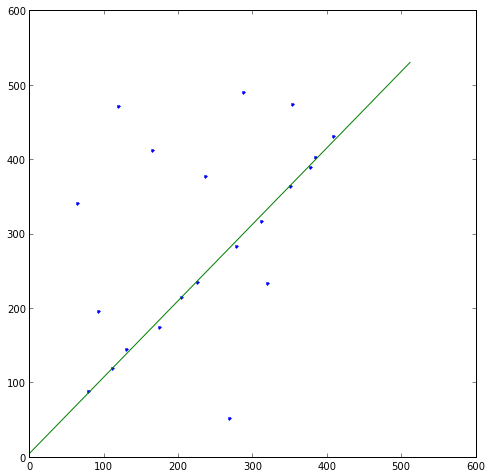

In [8]:
plot(points[:,0],points[:,1],'.')
m = mean(best[0:2]); b = mean(best[2:4])
plot([0,512],[b,m*512+b],'g-')

In [13]:

from matplotlib import patches
best_q = 0.0
best = None
def search(box):
    global best_q,best
    m0,m1,b0,b1 = box
    gca().add_patch(patches.Rectangle((m0,b0),m1-m0,b1-b0,edgecolor='red',facecolor='white'))
    q = evaluate(points,box)
    if q<=best_q: return
    if m1-m0<0.01 and b1-b0<2.0: 
        best_q = q
        best = box
        return
    mc = (m0+m1)/2
    bc = (b0+b1)/2
    search((m0,mc,b0,bc))
    search((mc,m1,b0,bc))
    search((m0,mc,bc,b1))
    search((mc,m1,bc,b1))

If we repeat that search with some graphics commands added, we see how effective the branch-and-bound algorithm is.



11.4816377258 (1.0234375, 1.03125, 3.90625, 4.296875)


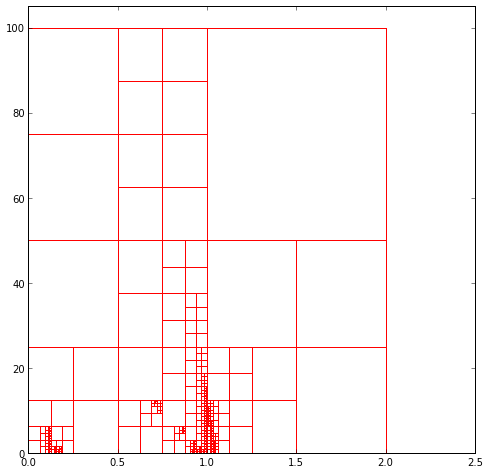

In [14]:
xlim((0,2.5)); ylim((0,105.0))
search((0.0,2.0,0.0,100.0))
print best_q,best